In [128]:
import string
import datetime
from dateutil import parser

import pandas as pd
import numpy as np
import spacy
import nltk

import multiprocessing as mp
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from setfit import SetFitModel, SetFitTrainer, sample_dataset
from huggingface_hub import notebook_login  

### Utilities

In [17]:
nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data
    
    
    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)
    

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)
    

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)
    

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)
    
    
    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

### Data preprocessing

In [42]:
not_spam_df = pd.read_csv('../../data/validation_data/non_spam_contenients.csv', index_col=0)
not_spam_df['spam'] = 0

In [ ]:
not_spam_normalizer = TextPreprocessor(nlp, -1)
not_spam_df['body_normalized'] = not_spam_normalizer.transform(not_spam_df['body'])

In [44]:
# spam_domains_df = pd.read_csv('../../data/validation_data/spam_domains.csv')
# spam_senders_df = pd.read_csv('../../data/validation_data/spam_senders.csv')

# The data is stored into this path in the repo
spam_domains_df = pd.read_csv('../../notebooks/validation_data/spam_domains.csv')
spam_senders_df = pd.read_csv('../../notebooks/validation_data/spam_senders.csv')

spam_domains_df['spam'] = 1
spam_senders_df['spam'] = 1

In [45]:
nlp = spacy.load("en_core_web_sm")
Normalizer = TextPreprocessor(nlp, -1)

In [ ]:
spam_domains_df['body_normalized'] = Normalizer.transform(spam_domains_df['body'])
spam_senders_df['body_normalized'] = Normalizer.transform(spam_senders_df['body'])

### Email Classifier Testing

In [108]:
full_df = pd.concat([not_spam_df[['spam', 'body', 'body_normalized']], spam_senders_df[['spam', 'body', 'body_normalized']]]).reset_index(drop=True)

In [109]:
full_df

,spam,body,body_normalized
0,0,The file was too big to email. It contains al...,file big email contain financial deal p b GD...
1,0,We have received an executed Master Agreement:...,receive execute Master Agreement type contract...
2,0,I know that WPTF is supporting Hebert's approa...,know WPTF support Hebert approach suggest star...
3,0,Do we need to meet this morning regarding our ...,need meet morning letter intent MSA
4,0,"Yes, they came to the last IEP meeting with a ...",yes come iep meet proposal ad campaign like ...
...,...,...,...
684,1,----------------------------------------------...,----------------------------------------------...
685,1,----------------------------------------------...,----------------------------------------------...
686,1,----------------------------------------------...,----------------------------------------------...
687,1,----------------------------------------------...,----------------------------------------------...


In [72]:
full_df.spam.value_counts()

0    391
1    298
Name: spam, dtype: int64

In [110]:
spam_senders_list = spam_senders_df['body'].to_list()

In [4]:
model = SetFitModel.from_pretrained("lewispons/email-classifiers", cache_dir='pretrained-models')

/Users/luis.morales/Desktop/MLOpsBootcamp/MLOpsCapstoneProject/mlopsenv/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [112]:
train_df, test_df = train_test_split(full_df, test_size=0.4)

In [113]:
test_df.spam.value_counts()

0    151
1    125
Name: spam, dtype: int64

In [123]:
%%time
spam_predictions = model(full_df['body'].to_list())

CPU times: user 1min 37s, sys: 12.2 s, total: 1min 50s
Wall time: 1min


In [124]:
full_df['spam_predicted'] = spam_predictions

In [125]:
cm = confusion_matrix(full_df['spam'],full_df['spam_predicted'])

In [126]:

print(classification_report(test_df['spam'],test_df['spam_predicted']))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63       151
           1       0.58      0.73      0.65       125

    accuracy                           0.64       276
   macro avg       0.65      0.65      0.64       276
weighted avg       0.65      0.64      0.64       276



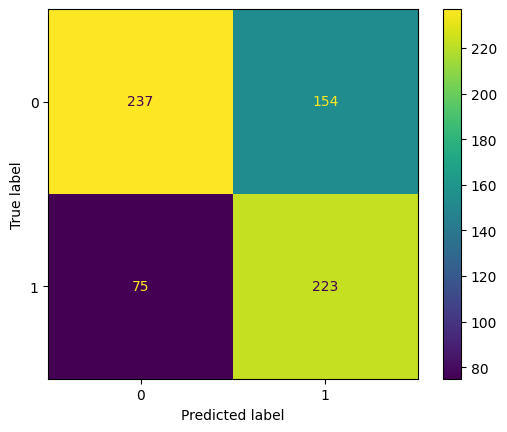

In [127]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [107]:
full_df[ (full_df['spam'] == 1) & (full_df['spam_predicted'] == 0)].to_csv('validaion_false_positives.csv')